In [2]:
# best ARIMA 추정
import numpy as np
import pandas as pd
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as scs

from arch import arch_model

def best_ARIMA(dataframe):
    best_bic = np.inf
    best_order = None
    best_model = None
    significance_level = 0.05

    for i in range(4):
        for j in range(4):
            try:
                # (i, d, j)th order에 대한 ARIMA 모형의 모수를 추정
                tmp_model = smt.ARIMA(dataframe, order=(i,0,j)).fit(method='mle', trend='nc')

                # 잔차의 white noise 여부를 검정
                tmp_diagnostic = sms.diagnostic.acorr_ljungbox(tmp_model.resid, lags=[20], boxpierce=False)[1][0]
                if tmp_diagnostic < significance_level:
                    continue

                # BIC 기준으로 최적의 모델을 결정
                tmp_bic = tmp_model.bic
                if tmp_bic < best_bic:
                    best_bic = tmp_bic
                    best_order = (i,0,j)
                    best_model = tmp_model
            except:
                continue

#     print("ARIMA",best_order,"is the best model")
    return best_bic, best_order, best_model


In [3]:
df = pd.read_csv("KODEX200.csv", index_col='Date')
df['Return'] = np.log(df.Close/df.Close.shift(1))
df.dropna(inplace=True)
df.head()

,Close,Return
Date,,
2002-10-18,8430.0,0.042405
2002-10-21,8200.0,-0.027663
2002-10-22,8020.0,-0.022196
2002-10-23,8260.0,0.029486
2002-10-24,8230.0,-0.003639


In [4]:
import warnings
warnings.simplefilter('ignore')
ret = df.Return.loc['2017-01-01':'2019-01-01']
foreLength = len(ret)
windowLength = 252

### Trading Strategy : 지난 1년간의 주가 수익률을 ARIMA모델링한 후 내일의 수익률 기대값이 양이면 매수, 음이면 매도

In [4]:
arima_signal = 0*ret[:]
for d in range(foreLength-windowLength):
    TS = ret[d:(windowLength + d)]
    res_tup = best_ARIMA(TS)
    order = res_tup[1]
    model = res_tup[2]
    
    forecast = model.forecast(steps=1)[0]
    arima_signal[windowLength+d] = np.where(forecast>0,1,-1)
    print("{} calculation completed".format(ret.index[windowLength+d]))
    print('best order: {}'.format(order))

2018-01-15 calculation completed
best order: (1, 0, 0)
2018-01-16 calculation completed
best order: (1, 0, 0)
2018-01-17 calculation completed
best order: (1, 0, 0)
2018-01-18 calculation completed
best order: (1, 0, 0)
2018-01-19 calculation completed
best order: (1, 0, 0)
2018-01-22 calculation completed
best order: (1, 0, 0)
2018-01-23 calculation completed
best order: (1, 0, 0)
2018-01-24 calculation completed
best order: (1, 0, 0)
2018-01-25 calculation completed
best order: (1, 0, 0)
2018-01-26 calculation completed
best order: (1, 0, 0)
2018-01-29 calculation completed
best order: (1, 0, 0)
2018-01-30 calculation completed
best order: (1, 0, 0)
2018-01-31 calculation completed
best order: (1, 0, 0)
2018-02-01 calculation completed
best order: (1, 0, 0)
2018-02-02 calculation completed
best order: (1, 0, 0)
2018-02-05 calculation completed
best order: (1, 0, 0)
2018-02-06 calculation completed
best order: (1, 0, 0)
2018-02-07 calculation completed
best order: (1, 0, 0)
2018-02-08

2018-08-23 calculation completed
best order: (0, 0, 2)
2018-08-24 calculation completed
best order: (0, 0, 2)
2018-08-27 calculation completed
best order: (0, 0, 2)
2018-08-28 calculation completed
best order: (0, 0, 2)
2018-08-29 calculation completed
best order: (0, 0, 2)
2018-08-30 calculation completed
best order: (0, 0, 2)
2018-08-31 calculation completed
best order: (0, 0, 2)
2018-09-03 calculation completed
best order: (0, 0, 2)
2018-09-04 calculation completed
best order: (0, 0, 2)
2018-09-05 calculation completed
best order: (0, 0, 2)
2018-09-06 calculation completed
best order: (0, 0, 2)
2018-09-07 calculation completed
best order: (0, 0, 2)
2018-09-10 calculation completed
best order: (0, 0, 2)
2018-09-11 calculation completed
best order: (0, 0, 2)
2018-09-12 calculation completed
best order: (0, 0, 2)
2018-09-13 calculation completed
best order: (0, 0, 2)
2018-09-14 calculation completed
best order: (0, 0, 2)
2018-09-17 calculation completed
best order: (0, 0, 2)
2018-09-18

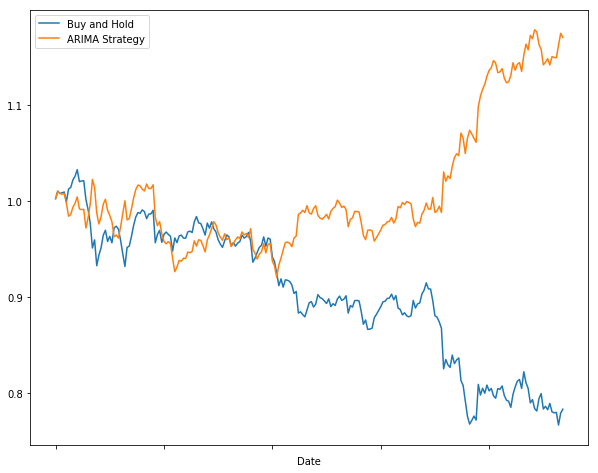

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

arima_signal_1 = pd.DataFrame(arima_signal[windowLength:])
returns = pd.DataFrame(index = arima_signal_1.index, 
                       columns=['Buy and Hold', 'ARIMA Strategy'])
returns['Buy and Hold'] = ret[windowLength:]
returns['ARIMA Strategy'] = arima_signal_1['Return'] * returns['Buy and Hold']
eqCurves = pd.DataFrame(index = arima_signal_1.index, 
                       columns=['Buy and Hold', 'ARIMA Strategy'])
eqCurves['Buy and Hold']=returns['Buy and Hold'].cumsum()+1
eqCurves['ARIMA Strategy'] = returns['ARIMA Strategy'].cumsum()+1


eqCurves.plot(figsize=(10,8))
plt.legend()
plt.show()

### Trading Strategy : 지난 1년간의 수익률로 ARIMA 모델을 세운후 남은 잔차에 대하여 GARCH(1,1)분석을 한다. 내일의 기대 수익률이 양수이면 매수 음수이면 매도

In [ ]:
garch_signal = 0*ret[:]
for d in range(foreLength-windowLength):
    TS = ret[d:(windowLength + d)]
    res_tup = best_ARIMA(TS)
    order = res_tup[1]
    model = res_tup[2]
    
    am = arch_model(model.resid, p=1, q=1, dist='StudentsT')
    res = am.fit(update_freq=5, disp='off')
    
    out = res.forecast(horizon=1, start=None, align='origin')
    garch_signal.iloc[windowLength+d] = np.sign(out.mean['h.1'].iloc[-1])

    print("{} calculation completed".format(ret.index[windowLength+d]))
    

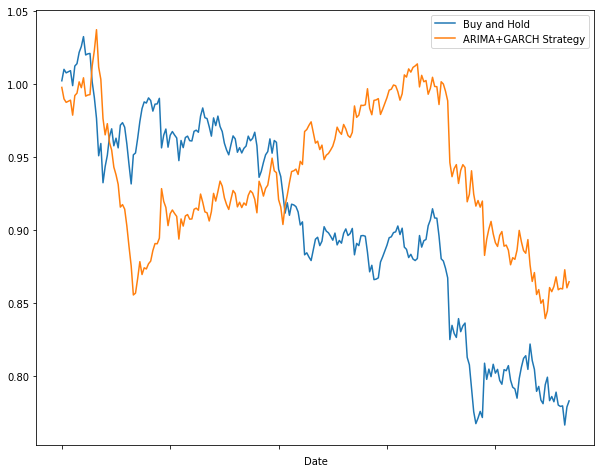

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

garch_signal_1 = pd.DataFrame(garch_signal[windowLength:])
returns2 = pd.DataFrame(index = garch_signal_1.index, 
                       columns=['Buy and Hold', 'ARIMA+GARCH Strategy'])
returns2['Buy and Hold'] = ret[windowLength:]
returns2['ARIMA+GARCH Strategy'] = garch_signal_1['Return'] * returns2['Buy and Hold']
eqCurves2 = pd.DataFrame(index = garch_signal_1.index, 
                       columns=['Buy and Hold', 'ARIMA+GARCH Strategy'])
eqCurves2['Buy and Hold']=returns2['Buy and Hold'].cumsum()+1
eqCurves2['ARIMA+GARCH Strategy'] = returns2['ARIMA+GARCH Strategy'].cumsum()+1


eqCurves2.plot(figsize=(10,8))
plt.legend()
plt.show()